# Download the corpus

In [ ]:
#wget --accept wav --mirror --page-requisites --adjust-extension --convert-links --backup-converted --no-parent https://media.talkbank.org/ca/CallHome/eng/0wav/


# Sentence level alignment

In [1]:
from os import walk, listdir
from pydub import AudioSegment
import re
import soundfile as sf

/opt/anaconda3/lib/python3.7/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
speechs = {}

class Speech():
    def __init__(self, identifier):
        self._id = identifier
        self.audio_path = './corpus/original_audio/'+identifier+'.wav'
        self.transc_path = './corpus/original_text/'+identifier+'.cha'
        self.sentences = [] #dictionnaries like {start (ms), end, text}

In [3]:
# creating instances
for filename in listdir('./corpus/original_audio/'):
        if filename.endswith('.wav'):
            _id = filename.split('.')[0]
            speechs[_id] = Speech(_id)

In [4]:
def get_clean_lines(content):
        try:
            content = re.split('@Media.*audio\n',content)[1]
        except:
            return 
        content = re.split('\n@End\n',content)[0]
        lines = re.split('(\x15.*\x15)', content)
        lines2 = []
        i = 0
        pattern = re.compile('\x15.*\x15')
        while i<len(lines):
            elem = lines[i]
            while not pattern.match(lines[i]) and i!=len(lines)-1: #tant ne contient pas (ou n'est pas) un timestamp:
                i += 1
                next_elem = lines[i]
                next_elem = next_elem.replace('*B:', ' ')
                next_elem = next_elem.replace('*A:', ' ')
                elem = elem + ' ' + next_elem #on concatenate avec l'élement suivant
            #quand on tombe sur un timestamp
            elem = elem.replace('\n\t', ' ')
            elem = elem.replace('\n', '')
            elem = elem.replace('\t','')
            elem = elem.replace('*A:',' ')
            elem = elem.replace('*B:',' ')
            elem= elem[1:]
            
            lines2.append(elem)
            i += 1 
    
        lines2 = lines2[:-1]
        return lines2

In [5]:
# Spotting the sentences
for speech in speechs.values():
        with open(speech.transc_path) as transc_file:
            content = transc_file.read()
            
        #splitting after each timestamp
        lines= get_clean_lines(content)
        if lines == None:
            continue
        
        for i in range(len(lines)):
            lines[i] = lines[i].rstrip()
        for line in lines:
            try:
                timestamp = re.search("\x15(.*)\x15", line).group(1)
            except:
                breakpoint()
            start = int(timestamp.split("_")[0])
            end = int(timestamp.split("_")[1])
            #breakpoint()
            text = re.search("(.*)\x15{}".format(timestamp),line).group(1)
            #writing in the speech object
            speech.sentences.append({'start':start,'end':end, 'text':text})
print("Sentences retrieved")

Sentences retrieved


In [6]:
# Creating files
for speech in speechs.values():
        print('Cutting {}'.format(speech.audio_path))
        data, samplerate = sf.read(speech.audio_path)
        for sent in speech.sentences:
            title = "{}_{}_{}".format(speech._id, sent['start'], sent['end'])
            cut = data[sent['start']*int((samplerate/1000)):sent['end']*int((samplerate/1000))]
            sf.write('./corpus/alignment/sentence_level_audio/{}.wav'.format(title),cut , samplerate)
            with open('./corpus/alignment/sentence_level_text/{}.txt'.format(title),'w') as outfile:
                print(sent['text'], file = outfile)

Cutting ./corpus/original_audio/0638.wav


# Filtering non-filler utterances

In [7]:
import glob
import re

In [9]:
pattern = re.compile('(mhm|uhhuh|mm|um|eh|em|ah|huh|ha|er|oof|hee|ach|eee|ew)')

for file in glob.iglob('./corpus/alignment_sentence_level_text/'):
    filename = file.split('.')[-1]
    filename = filename.split('.')[0]
    has_filler = False
    with open(file,'r', encoding = 'utf-8') as infile:
        content = infile.read()
        matched = re.match(pattern, content)
        has_filler = bool(matched)
    if not has_filler:
        system('rm {}'.format(file))
        system('rm ./corpus/alignment_sentence_level_audio/{}.wav'.format(filename))

# Word level alignment

In [10]:
from os import system

In [12]:
# Converting the audio sentences into mono
path = './corpus/alignment/sentence_level_audio/'
for filename in listdir(path):
    system('sox {}{} {}{} remix 1,2'.format(path, filename, path, filename))

In [13]:
# Preparing the setup for MFA
# (converting .txt to .lab, and moving .lab and .wav sentence level into the same folder)

for filename in listdir('./corpus/alignment/sentence_level_audio'):
    _id = filename.split('.')[0]
    system('mv ./corpus/alignment/sentence_level_audio/{}.wav ./corpus/alignment/mfa_setup/{}.wav '.format(_id,_id))
    system('mv ./corpus/alignment/sentence_level_text/{}.txt ./corpus/alignment/mfa_setup/{}.lab'.format(_id,_id))
    

In [ ]:
mfa_path = ??? # Replace with the installation directory of Montreal Forced Aligner
lm_path = '../corpus/alignment/librispeech-lexicon.txt' # Language model
lab_wav_path = '../corpus/alignment/mfa_setup'
output_path = '../corpus/alignment/textgrids'


In [ ]:
# mfa command
system('{}\bin\mfa_align.exe -v  {} {} english {}'.format(mfa_path, lm_path, lab_wav_path, output_path))


# Data preparation

In [7]:
import textgrids as tg
import pandas as pd

In [15]:
hesitations = [
    'mhm',
    'uhhuh',
    'mm',
    'um',
    'eh',
    'em',
    'ah',
    'huh',
    'ha',
    'er',
    'oof',
    'hee',
    'ach',
    'eee',
    'ew'
]

silence = ['sp', 'sil','']

def tag_word(word):
    if word in hesitations: 
        return 'hesitation'
    elif word in silence:
        return 'silence'
    else:
        return 'speech'

**You can jump until the end if you have the pickles**

In [16]:
words_df = pd.DataFrame(columns=['file','word','tag','xmin','xmax'])
files_df = pd.DataFrame(columns=['file', 'xmin','xmax'])

In [20]:
for filename in listdir('./corpus/alignment/textgrids'):
    if not filename.endswith('.TextGrid'):
        continue
    name = filename.split('.')[0]
    the_tg = tg.TextGrid('./corpus/alignment/textgrids/'+filename)
    
    # Filling the dataframe of files
    files_df.loc[len(files_df)] = {'file':name,
                            'xmin':the_tg.xmin,
                            'xmax':the_tg.xmax}
    
    # Filling the dataframe of words 
    for word in the_tg['words']:
        words_df.loc[len(words_df)] = {'file':name,
                             'word':word.text,
                             'tag':tag_word(word.text),
                             'xmin':word.xmin,
                             'xmax':word.xmax
                            }

## Words dataframe

In [21]:
words_df.head()

,file,word,tag,xmin,xmax
0,0638_440130_440740,um,hesitation,0.00,0.59
1,0638_440130_440740,,silence,0.59,0.61
2,0638_210130_210500,uhhuh,hesitation,0.00,0.35
3,0638_210130_210500,,silence,0.35,0.37
4,0638_694970_696670,mm,hesitation,0.00,0.51


In [22]:
words_df['duration'] = words_df['xmax']-words_df['xmin']

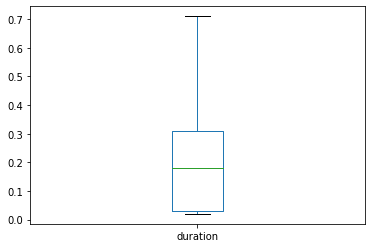

In [24]:
words_df['duration'].plot.box()

In [25]:
# converting to ms
words_df['xmin'] = words_df['xmin'].apply(lambda x: int(x*1000))
words_df['xmax'] = words_df['xmax'].apply(lambda x: int(x*1000))
words_df['duration'] = words_df['duration'].apply(lambda x: int(x*1000))

In [26]:
words_df.groupby('tag').count().file

tag
hesitation    52
silence       86
speech        73
Name: file, dtype: int64

## Files dataframe

In [27]:
files_df.head()

,file,xmin,xmax
0,0638_440130_440740,0.0,0.61
1,0638_210130_210500,0.0,0.37
2,0638_694970_696670,0.0,1.70
3,0638_388380_388790,0.0,0.41
4,0638_710110_710620,0.0,0.51


In [28]:
files_df['duration'] = files_df['xmax']-files_df['xmin']

In [29]:
# converting to ms
files_df['xmin'] = files_df['xmin'].apply(lambda x: int(x*1000))
files_df['xmax'] = files_df['xmax'].apply(lambda x: int(x*1000))
files_df['duration'] = files_df['duration'].apply(lambda x: int(x*1000))

## Saving

In [31]:
words_df.to_pickle('./pickles/words_df.pkl')
files_df.to_pickle('./pickles/files_df.pkl')

## Loading

In [8]:
words_df = pd.read_pickle('./pickles/words_df.pkl')
files_df = pd.read_pickle('./pickles/files_df.pkl')

# Framing audios

In [2]:
import torch

In [34]:
def tag_decision_med(filename, xmin, xmax):
    # Taking the median sample
    med = int((xmin+xmax)/2)
    query = words_df.query("file=='{}' and {} >= xmin and {} <= xmax ".format(filename, med, med))
    tag = query.iloc[0]['tag']
    return tag

In [35]:
tag2int = {
    '<dummy>':0,
    'speech':1,
    'silence':2,
    'hesitation':3
}

In [13]:
sampling_rate = 16000
win_shift = 12.5
win_len = 12.5
numb_files = len(files_df)
max_len = int(files_df['duration'].max() // win_len)

**Skip the following if you have tags.pt**

In [37]:
Y = torch.zeros((numb_files,max_len))

In [38]:
i,j = 0,0

for audiofile in files_df['file']:
    j = 0
    filename = audiofile
    file_df = files_df.query("file == '{}'".format(filename))
    duration = file_df.iloc[0]['duration']
    head = 0
    while head + win_shift <= duration:
        try:
            tag = tag2int[tag_decision_med(filename, head, head+win_len )]
            Y[i][j] = tag
        except:
            continue
        head += win_shift
        j += 1
    i += 1
    print('{} / {}'.format(i,numb_files))

1 / 52
2 / 52
3 / 52
4 / 52
5 / 52
6 / 52
7 / 52
8 / 52
9 / 52
10 / 52
11 / 52
12 / 52
13 / 52
14 / 52
15 / 52
16 / 52
17 / 52
18 / 52
19 / 52
20 / 52
21 / 52
22 / 52
23 / 52
24 / 52
25 / 52
26 / 52
27 / 52
28 / 52
29 / 52
30 / 52
31 / 52
32 / 52
33 / 52
34 / 52
35 / 52
36 / 52
37 / 52
38 / 52
39 / 52
40 / 52
41 / 52
42 / 52
43 / 52
44 / 52
45 / 52
46 / 52
47 / 52
48 / 52
49 / 52
50 / 52
51 / 52
52 / 52


In [39]:
print(Y.shape)

torch.Size([52, 323])


In [40]:
print(Y)

tensor([[3., 3., 3.,  ..., 0., 0., 0.],
        [3., 3., 3.,  ..., 0., 0., 0.],
        [3., 3., 3.,  ..., 0., 0., 0.],
        ...,
        [3., 3., 3.,  ..., 0., 0., 0.],
        [2., 2., 3.,  ..., 0., 0., 0.],
        [3., 3., 3.,  ..., 0., 0., 0.]])


In [43]:
torch.unique(Y, return_counts = True)

(tensor([0., 1., 2., 3.]), tensor([13593,  1495,   305,  1403]))

## Saving

In [45]:
torch.save(tags,'./pickles/Y.pt')

## Loading

In [3]:
Y = torch.load('./pickles/Y.pt')

# MFCC Extraction

In [4]:
import torchaudio

In [11]:
mfcc_tensors = []

for audiofile in files_df['file']:
    waveform, sample_rate = torchaudio.load('./corpus/alignment/mfa_setup/'+audiofile+'.wav')
    mfcc = torchaudio.transforms.MFCC(n_mfcc=13)(waveform)
    torch.set_printoptions(sci_mode=False)
    mfcc_tensors.append(mfcc)

In [14]:
padded_tensors = []

for tensor in mfcc_tensors:
    target = torch.zeros(1, 13, max_len+1)
    source = tensor
    target[:, :, :tensor.shape[2]] = source
    padded_tensors.append(target)

In [15]:
X = torch.cat((padded_tensors), dim=0)

In [16]:
X.shape

torch.Size([52, 13, 324])

In [17]:
X = torch.narrow(X, 2, 0, max_len)

In [18]:
X.shape

torch.Size([52, 13, 323])

In [19]:
Y.shape

torch.Size([52, 323])

In [20]:
Y = Y.unsqueeze(1)

In [21]:
Y.shape

torch.Size([52, 1, 323])

## Saving

In [22]:
torch.save(X,'./pickles/X.pt')
torch.save(Y,'./pickles/Y.pt')

## Loading

In [24]:
X = torch.load('./pickles/X.pt')
Y = torch.load('./pickles/Y.pt')

# RNN Tagging

In [25]:
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [26]:
X = torch.load('./pickles/X.pt')
Y = torch.load('./pickles/Y.pt').squeeze(1)

In [27]:
print(X.shape)
print(Y.shape)

torch.Size([52, 13, 323])
torch.Size([52, 323])


In [28]:
BATCH_SIZE = 32
N_STEPS = X.shape[2]
N_INPUTS = 13
N_NEURONS = 150
N_OUTPUTS = 4
N_EPHOCS = 50
LR = 0.05

In [29]:
X_train, X_valid = X[:2500], X[2500:]
Y_train, Y_valid = Y[:2500], Y[2500:]

train_set = TensorDataset(X_train, Y_train)
valid_set = TensorDataset(X_valid, Y_valid)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE)

In [30]:
class RNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(RNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons)
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2)

        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()

        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)
        out = self.FC(lstm_out)

        return out.view(-1, self.n_outputs) # batch_size X n_output

In [31]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = RNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss(size_average=True, ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=LR)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100 * corrects/batch_size
    return accuracy.item()

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [32]:
for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    outs = []
    golds = []
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(train_loader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, N_STEPS, N_INPUTS)

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels.long().view(-1))
        
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels.long().view(-1), BATCH_SIZE)
        
        out = torch.max(outputs, 1)[1].view(labels.long().view(-1).size()).data
        gold = labels.long().view(-1).data
        outs.append(out)
        golds.append(gold)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch+1, train_running_loss/i, train_acc/(i*N_STEPS)))
    
    y_pred = torch.cat(outs)
    y_gold = torch.cat(golds)

    print(confusion_matrix(y_gold, y_pred, labels=[1, 2, 3]))
    print(classification_report(y_gold, y_pred, labels=[1, 2, 3]))

../aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Epoch:  1 | Loss: 3.3945 | Train Accuracy: 19.16
[[533 230 635]
 [164  21 108]
 [710 145 441]]
              precision    recall  f1-score   support

           1       0.06      0.36      0.10      1495
           2       0.01      0.07      0.02       305
           3       0.09      0.31      0.14      1403

   micro avg       0.06      0.31      0.11      3203
   macro avg       0.05      0.25      0.09      3203
weighted avg       0.07      0.31      0.11      3203

Epoch:  2 | Loss: 5.3074 | Train Accuracy: 50.35
[[375 496 301]
 [ 67  98  61]
 [345 320 343]]
              precision    recall  f1-score   support

           1       0.09      0.25      0.13      1495
           2       0.03      0.32      0.05       305
           3       0.09      0.24      0.13      1403

   micro avg       0.07      0.25      0.11      3203
   macro avg       0.07      0.27      0.10      3203
weighted avg       0.08      0.25      0.12      3203

Epoch:  3 | Loss: 3.9629 | Train Accuracy: 57.08

Epoch:  19 | Loss: 2.0535 | Train Accuracy: 13.91
[[687   0 808]
 [139   0 166]
 [655   1 747]]
              precision    recall  f1-score   support

           1       0.08      0.46      0.14      1495
           2       0.00      0.00      0.00       305
           3       0.09      0.53      0.15      1403

   micro avg       0.09      0.45      0.14      3203
   macro avg       0.06      0.33      0.10      3203
weighted avg       0.08      0.45      0.13      3203

Epoch:  20 | Loss: 1.9936 | Train Accuracy: 14.42
[[776   0 719]
 [150   0 155]
 [688   0 715]]
              precision    recall  f1-score   support

           1       0.09      0.52      0.16      1495
           2       0.00      0.00      0.00       305
           3       0.09      0.51      0.15      1403

   micro avg       0.09      0.47      0.15      3203
   macro avg       0.06      0.34      0.10      3203
weighted avg       0.08      0.47      0.14      3203

Epoch:  21 | Loss: 2.0857 | Train Accuracy: 13

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch:  22 | Loss: 2.0066 | Train Accuracy: 14.84
[[846   0 649]
 [162   0 143]
 [715   0 688]]
              precision    recall  f1-score   support

           1       0.09      0.57      0.16      1495
           2       0.00      0.00      0.00       305
           3       0.09      0.49      0.15      1403

   micro avg       0.09      0.48      0.15      3203
   macro avg       0.06      0.35      0.10      3203
weighted avg       0.08      0.48      0.14      3203

Epoch:  23 | Loss: 2.0552 | Train Accuracy: 13.78
[[575   0 920]
 [122   0 183]
 [553   0 850]]
              precision    recall  f1-score   support

           1       0.09      0.38      0.14      1495
           2       0.00      0.00      0.00       305
           3       0.08      0.61      0.15      1403

   micro avg       0.08      0.44      0.14      3203
   macro avg       0.06      0.33      0.10      3203
weighted avg       0.08      0.44      0.13      3203

Epoch:  24 | Loss: 2.0422 | Train Accuracy: 14

Epoch:  40 | Loss: 2.0340 | Train Accuracy: 13.26
[[614   0 881]
 [136   1 168]
 [643   4 756]]
              precision    recall  f1-score   support

           1       0.07      0.41      0.13      1495
           2       0.05      0.00      0.01       305
           3       0.09      0.54      0.15      1403

   micro avg       0.08      0.43      0.14      3203
   macro avg       0.07      0.32      0.09      3203
weighted avg       0.08      0.43      0.13      3203

Epoch:  41 | Loss: 2.0468 | Train Accuracy: 13.92
[[595  12 888]
 [135   3 167]
 [556   6 841]]
              precision    recall  f1-score   support

           1       0.09      0.40      0.14      1495
           2       0.05      0.01      0.02       305
           3       0.09      0.60      0.15      1403

   micro avg       0.09      0.45      0.14      3203
   macro avg       0.07      0.34      0.10      3203
weighted avg       0.08      0.45      0.13      3203

Epoch:  42 | Loss: 2.0291 | Train Accuracy: 14

In [ ]:
test_acc = 0.0
outs = []
golds = []

for i, data in enumerate(valid_loader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, N_STEPS, N_INPUTS)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels.long().view(-1), BATCH_SIZE)
    out = torch.max(outputs, 1)[1].view(labels.long().view(-1).size()).data
    gold = labels.long().view(-1).data
    outs.append(out)
    golds.append(gold)
        
print('Test Accuracy: %.2f'%(test_acc/(i*N_STEPS)))

y_pred = torch.cat(outs)
y_gold = torch.cat(golds)

print(confusion_matrix(y_gold, y_pred, labels=[1, 2, 3]))
print(classification_report(y_gold, y_pred, labels=[1, 2, 3]))

In [ ]:
cm1 = pd.DataFrame({'speech':[307140,673,894],'silence':[67293,146,147],'filler':[77599,198,292]}, index=["speech", "silence", "filler"])
matrix = sns.heatmap(cm1.T, annot=True, fmt='d', linewidths=.5, cmap='coolwarm')
matrix.set(xlabel='predicted label', ylabel='true label')

In [ ]:
cm = pd.DataFrame({'speech':[38602,0,0],'silence':[8888,0,0],'filler':[11674,0,0]}, index=["speech", "silence", "filler"])
matrix = sns.heatmap(cm.T, annot=True, fmt='d', linewidths=.5, cmap='coolwarm')
matrix.set(xlabel='predicted label', ylabel='true label')